# Cerebellar-driven cortical dynamics
Welcome to the "cerebellar-driven cortical dynamics" notebook! This notebook provides background into my own (Joe Pemberton's) research on the cortico-cerebellar loop. In particular, I have spent some time developing an artifical neural network based model of cortico-cerebellar interaction in the brain during task acquistion. Using the model, we can show that cerebellar plasticity alone is often enough to drive efficient task dynamics. We can also use the model to replicate *in silico* some exciting recent experimental results. For more context for this notebook, see [this preprint paper](https://scholar.google.com/citations?view_op=view_citation&hl=en&user=B9nk9MQAAAAJ&citation_for_view=B9nk9MQAAAAJ:eQOLeE2rZwMC).

In this notebook, first we will go through the background of the model and its implementation. Next we will apply the model to a 'motor-switching' paradigm as in Figure 3 as in [here](https://scholar.google.com/citations?view_op=view_citation&hl=en&user=B9nk9MQAAAAJ&citation_for_view=B9nk9MQAAAAJ:eQOLeE2rZwMC). Finally, I will provide suggestions this work could be extended (but for which I didn't have time to do myself!).

## Background: model architecture and plasticity rules
<img src="https://user-images.githubusercontent.com/35163856/202711207-297cb6db-2a4f-4b1f-989f-f76600c2d1ee.png" width="900">

In this study we will model the temporal dynamics of the brain and how it can solve time-dependent tasks. We separate the model into two distinct components: a **cortical** component - which models some region of the neocortex -- and a **cerebellar** component -- which models some region of the cerebellum. 

### (Cortical only) no feedback model

Cortical circuits, particularly in higher brain areas responsible for solving tasks, are highly recurrent. For this reason we model the cortical network as a recurrent neural network (RNN), where the RNN state $h_t$ represents the 'hidden' cortical state at time $t$. The RNN takes external input $x_t$, and the final cortical output $z_t$ is a linear readout of the hidden state. Let $W_{ih}$, $W_{hh}$ and $W_\mathrm{rdt}$ denote the input, recurrent and readout weights (synapses) of the cortical network respectively. Then the dynamics of the network can be formally described with

$h_t = \alpha h_{t-1} + W_{hh}f(h_{t-1}) + W_{ih} x_t$ 

$ z_t = W_{\mathrm{rdt}}f(h_t)$

Where $\alpha$ denotes the leak of the RNN which is dependent on the membrane time constant of the cortical neurons, and $f$ is the activation function of the RNN which we take as $f(x) = \tanh(x)$.

The above equations are the standard implementation of a leaky RNN and reflect the 'no feedback' architecture in the above figure. 

### (Cortical only) readout feedback model

In this lab we will examine the role that feedback can play onto an RNN. The most obvious way to incorporate feedback is to send the cortical output $z_t$ back into the RNN. This architecture is represented in the 'readout feedback' model in the above figure, and is used in various works in the 2000s including in [echo-state networks](https://www.science.org/doi/10.1126/science.1091277) and the [FORCE](https://pubmed.ncbi.nlm.nih.gov/19709635/) algorithm. Letting $W_{\mathrm{out},h}$ denote the feedback weights from the cortical output to the RNN, the hidden cortical state now evolves according to

$h_t = \alpha h_{t-1} + W_{hh}f(h_{t-1}) + W_{ih} x_t + W_{\mathrm{out}-h} z_{t-1}$ 

This is an important control architecture to consider whilst examining the role of cerebellar feedback. 

### Cerebellar feedback model

The novel architecture that we will examine! In this scheme we attach a cerebellar network to the cortical network; the cerebellar network receives a copy of cortical activity, and sends back a cerebellar prediction. This architecture resembles the cortico-cerebellar loop and is the 'cerebellar feedback' model in the above figure. Letting $\mathcal{C}$ denote the cerebellar computation and $W_{\mathcal{C}h}$ the cerebellar-cortico weights, the temporal dynamics then run according to 

$h_t = \alpha h_{t-1} + W_{hh}f(h_{t-1}) + W_{ih} x_t + W_{\mathcal{C}h} c_{t}$ 

$c_{t} = \mathcal{C}(f(h_{t-1}))$

What is the cerebellar computation $\mathcal{C}$? We approximate cerebellar processing with two main stages of forward processing. The first stage is the projection from the cortex onto the granular layer of the cerebellum via the mossy fibres; the second stage is the projection from the granule cells onto the Purkinje cells via the parallel fibres. Together, these stages can be approximated by a feedforward network of one hidden layer, where the hidden and output units of the network resemble granule and Purkinje cells, respectively. In particular, the cerebellar computation is

$c_{t} = \mathcal{C}(f(h_{t-1})) = W_{\mathrm{PF}}f^{\mathcal{C}}\left(W_{\mathrm{MF}}f(h_{t-1})\right)$

where $W_{\mathrm{MF}}$, $W_{\mathrm{PF}}$ denote the mossy fibre, parallel fibre weights respectively, and $f^{\mathcal{C}}$ denotes the cerebellar non-linearity which we set as $f^{\mathcal{C}}(x) = \mathrm{ReLU}(x)$. Like the real cerebellum, we generally consider a high number of granule cells, e.g. a 1:20 divergence from the cortical neurons to the cerebellar granular layer. 

### Cortical plasticity rules

As stated earlier, we're interested in how the brain can learn time-dependent tasks. Here we're going to be considering the supervised learning paradigm in which some external 'teacher' provides the desired output to the model. Let $y_t$ denote the desired output at time $t$. The goal of the model then is to minimise the error between the cortical output and desired output, $E_t = \mathcal{E}(y_t, z_t)$, where $\mathcal{E}$ is the task error function (e.g. mean-squared error for regression tasks, cross entropy loss for classification tasks). 

Let $E = \sum_t E_t$ denote the task error across the entire task sequence. To minimise $E$, we will update our cortical parameters by gradient descent. That is, for a given cortical weight $W$

$\Delta W = - \eta \frac{\partial E}{\partial W}$

Where $\eta$ is the learning rate. Though $\frac{\partial E}{\partial W}$ is relatively simply to compute for the cortical readout weight $W = W_{\mathrm{rdt}}$ (one-step backprop in space), solving this gradient for the parameters in the RNN can be challenging. In particular, determining the true gradient normally uses the backpropagation through time (BPTT) algorithm, the computational and memory requirements of which are generally considered [biologically implausible](https://www.sciencedirect.com/science/article/pii/S0959438818302009) in the brain. For this reason, when assumed plastic, we instead use forward-propagating, biologically plausible eligibility traces as in the [eprop algorithm](https://www.nature.com/articles/s41467-020-17236-y). However, as we will see, cerebellar feedback can alleviate the need for plasticity in the cortical RNN at all. 

### Cerebellar plasticity rules

How does the cerebellar network learns? The parallel fibre weights $W_{\mathrm{PF}}$ are updated so that the cerebellum predicts *future* task targets. Specifically, the cerebellar error is $E^\mathcal{C}_t = \mathcal{E}(y_t, c_{t-\tau})$ for some cerebellar time window $\tau$. This appeals to the observed timed plasticity rules at the parallel fibre synapse, for which $\tau$ effectively varies in the hundreds of milliseconds. Moreover, the predictive element of cerebellar output appeals to the notion of the cerebellum as an [internal model](https://www.sciencedirect.com/science/article/pii/S1364661398012212) (specifically forward model) of the nervous system. 

## Required libraries and functions
Let's load the required python libraries...

In [16]:
import os, sys
import torch
import ignite
import numpy as np
import matplotlib.pyplot as plt
import sacred
from sacred import Experiment
from ignite.engine import Events

import logging
logging.getLogger("ignite").setLevel(logging.WARNING) 

... and functions

In [17]:
# Load experiment ingredients
from ingredients.dataset import linedraw as dataset, load_linedraw as load_dataset
    
from ingredients.model import model, init_model
from ingredients.training import training, init_metrics, init_optimizer, \
                                 create_rnn_trainer, create_rnn_evaluator, \
                                 Tracer, ModelCheckpoint


In [18]:
training.add_config('multitask/configs/training.yaml')
model.add_config('multitask/configs/model.yaml')
dataset.add_config('multitask/configs/dataset.yaml')

## Pre-experiment booking
Inspired by the vast number of granule cells in the cerebellum (they constitute $>50\%$ of the brain's neurons alone!), we apply a significant cortico-cerebellar expansion

In [4]:
OBSERVE = False #save model results
temp_path = 'sims/temp' #in case saving stuff

ex = Experiment(name='testing', ingredients=[dataset, model, training], interactive=True)
ex.add_config(no_cuda=False, save_folder=temp_path,
              experiment_name='multi-task')

ex.add_package_dependency('torch', torch.__version__)
if OBSERVE:
    ex.observers.append(FileStorageObserver.create('sims'))

Helper function for setting seed/device..

In [19]:
# Functions
@ex.capture
def set_seed_and_device(seed, no_cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available() and not no_cuda:
        torch.cuda.manual_seed(seed)
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')

    return device

## Define main method

In [23]:
@ex.main
def main(_config, seed):
    global task1_mse_pre
    global task2_mse
    global task1_mse_post
    
    global pred_task1_baseline
    global pred_task2
    global pred_task1_switch
    
    global targets_task1
    global targets_task2
    global targets_task1
    
    , , 
    
    , , 
    
    no_cuda = _config['no_cuda']
    print("config:", _config)
    
    assert _config['model']['apply_cerebellum'] == True, 'This task requires the cerebellum!'
    epochs = _config['training']['epochs']
        
    input_size = _config['dataset']['input_D']
    output_size = 2
    seq_len =  _config['dataset']['seq_len']
    classification = False      
    predict_last = False     
    
    log_interval = 5
    batch_size = _config['training']['batch_size']

    # Init metrics
    loss, metrics = init_metrics('mse', ['mse'])

    device = set_seed_and_device(seed, no_cuda)
    
    training_set, validation_set, test_set = load_dataset(batch_size=batch_size)
    print("retrieved dataset")  
    model = init_model(input_size=input_size, output_size=output_size)
    print("initialised model")    

    model.init_dataset_details(batch_size, seq_len, classification,
                                 predict_last)    
        
    model = model.to(device=device)
    model.set_2task_model() #multi-task learning
    
    optimizer = init_optimizer(model=model) 
    
    # Init engines
    trainer = create_rnn_trainer(model, optimizer, loss, device=device)
    validator = create_rnn_evaluator(model, metrics, device=device)

    @trainer.on(Events.EPOCH_STARTED)
    def print_epoch(engine):
        nepoch = engine.state.epoch
        if nepoch % log_interval == 0:
            print('#'*75)
            print("Epoch: {}".format(engine.state.epoch))   
            print('#'*75)
        
    @trainer.on(Events.EPOCH_COMPLETED)
    def validate(engine):
        validator.run(validation_set)
    
    # Exception for early termination
    @trainer.on(Events.EXCEPTION_RAISED)
    def terminate(engine, exception):
        if isinstance(exception, KeyboardInterrupt):
            engine.should_terminate=True

    # Record training progression
    global tracer
    tracer = Tracer(metrics).attach(trainer)

    @trainer.on(Events.EPOCH_COMPLETED)
    def log_training(engine):        
        loss_epoch = tracer.loss[-1]
        ex.log_scalar('training_loss', loss_epoch)
        tracer.loss.clear()
        
        if model.apply_cerebellum and model.cerebellum.record_losses:
            for IO_type, error_list in model.cerebellum.recorded_losses.items():
                name = 'cerebellar_{}_loss'.format(IO_type)
                loss_epoch = np.nanmean(error_list)
                ex.log_scalar(name, loss_epoch)
                
                error_list.clear()
                    
    val_metrics = {}
    for key in metrics.keys():
        val_metrics[key] = []

    @validator.on(Events.EPOCH_COMPLETED)
    def log_validation(engine):
        for metric, value in engine.state.metrics.items():
            if 'mse' in metric: #correct for difference between torch.lossMSE and ignite.lossMSE
                if not model.predict_last:
                    value = value/seq_len 
                if metric == 'mse':
                    value = value/output_size
            
            print("Val loss:", value)
            ex.log_scalar('val_{}'.format(metric), value)
            val_metrics[metric].append(value)

    # Attach model checkpoint
    def score_fn(engine):
        return -engine.state.metrics[list(metrics)[0]]

    global checkpoint
    checkpoint = ModelCheckpoint(
        dirname=_config['save_folder'],
        filename_prefix='disent',
        score_function=score_fn,
        create_dir=True,
        require_empty=False,
        save_as_state_dict=True
    )
    
    validator.add_event_handler(Events.COMPLETED, checkpoint, {'model': model})
    
    print("epochs is", epochs)
    
    print("starting training for task 1")
    trainer.run(training_set, max_epochs=epochs)
    print("finished training for task 1")
            
    #save final model (not necessarily best)
    final_model_path = temp_path + 'final-model.pt'
    torch.save(model.state_dict(), final_model_path)
    ex.add_artifact(final_model_path, 'final-model.pt')
    os.remove(final_model_path)
        
    # Run on test data
    model.eval()
    model.load_state_dict(checkpoint.best_model)
    tester = create_rnn_evaluator(model, metrics, device=device,)

    test_metrics = tester.run(test_set).metrics
    
    # Save best model performance and state
    for metric, value in test_metrics.items():
        print("Test {}: {}".format(metric, value))
        ex.log_scalar('test_{}'.format(metric), value)
    #ex.add_artifact(checkpoint.last_checkpoint, 'trained-model')
    ex.add_artifact(checkpoint.last_checkpoint, 'best-model.pt')
    
    os.remove(checkpoint.last_checkpoint)   
    
    model.eval()
    task1_mse_pre = tester.run(test_set).metrics['mse']
    data_task1, targets_task1 = next(iter(test_set))
    pred_task1_baseline, _ = model(data_task1)
        
    #consider new task with distinct cerebellar weights 
    pf_overlap = None #ratio of same PFs to use across tasks (None is zero)
        
    print("cereb parms at end of baseline:", model.cerebellum.input_trigger.weight[0,:5])
    model.set_task_number(1, pf_overlap=pf_overlap) 
    
    trainer.remove_event_handler(validate, Events.EPOCH_COMPLETED)
    
    # need to make sure the optimiser is updating the correct cerebellar weights
    del optimizer.param_groups[2]
    optimizer.add_param_group(
        {'params' : model.cerebellum.parameters()}
        )     
    
    training_set2, validation_set2, test_set2 = load_dataset(arc=1, 
                                                            batch_size=batch_size,)
    
    @trainer.on(Events.EPOCH_COMPLETED)
    def validate(engine):
        validator.run(validation_set2)
    
    
    trainer.state.max_epochs = None
    nepochs_task2 = 10
    print("starting training for task 2")
    trainer.run(training_set2, max_epochs=nepochs_task2)
    print("finished training for task 2")
            
    model.eval()
    task2_mse = tester.run(test_set2).metrics ['mse']   
    data_task2, targets_task2 = next(iter(test_set2))
    pred_task2, _ = model(data_task2)    
    
    model.set_task_number(0)
    
    task1_mse_post = tester.run(test_set).metrics['mse']
    pred_task1_switch, _ = model(data_task1)

## Run experiment!

In [24]:
  r = ex.run(config_updates={'training': {'epochs': 5},
               'model': {'apply_cerebellum': True,},
               'seed': 123})

WARNING - testing - No observers have been added to this run
INFO - testing - Running command 'main'
INFO - testing - Started
/home/joe/Documents/other/workshops/mainz_2023/labs/ccLoops-main/src/dataset/linedraw.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  alpha = np.arctan(opp/adj) #sohcahtoa!


config: {'no_cuda': False, 'save_folder': 'sims/temp', 'experiment_name': 'multi-task', 'seed': 123, 'dataset': {'seq_len': 20, 'training_size': 1000, 'test_size': 1000, 'train_val_split': 0.2, 'fixdata': False, 'train_noise_var': 0.1, 'test_noise_var': 0.1, 'input_D': 10, 'npoints': 6, 'mag': 1, 'arc': 0, 'equal_spacing': False}, 'model': {'rnn_type': 'RNN_eprop', 'n_layers': 1, 'hidden_size': 50, 'input_size': 2, 'output_size': 1, 'evec_scale': None, 'readout_from_cereb': False, 'apply_cerebellum': True, 'bias': False, 'fixed_rnn': True, 'alpha': 0.5, 'cereb_params': {'pons_sizes': {'PFC_pons_size': None, 'MC_pons_size': 0, 'targ_pons_size': 0, 'inp_pons_size': 0}, 'IO_sizes': {'PFC_IO_size': 0, 'MC_IO_size': 0, 'targ_IO_size': None, 'inp_IO_size': 0}, 'IO_delays': {'PFC_IO_delay': 5, 'MC_IO_delay': 3, 'targ_IO_delay': 3, 'inp_IO_delay': 2}, 'hidden_size': 1000, 'num_hidden_layers': 1, 'nfibres': None, 'zero_output': False, 'bias': False, 'do_final_learning': True, 'temp_basis': Fals

INFO - testing - Completed after 0:00:32


NameError: name 'pred_task1_baseline' is not defined

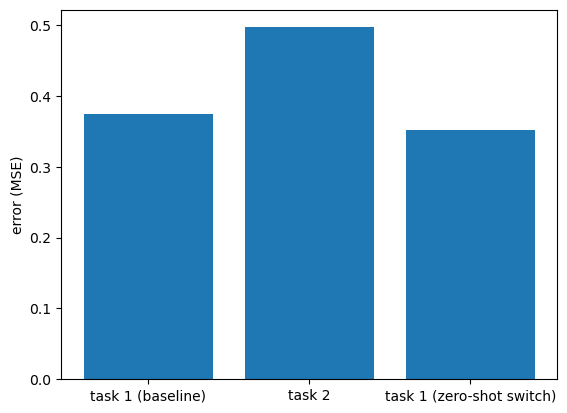

<Figure size 600x200 with 0 Axes>

In [25]:
    fig = plt.figure(0)
    x = np.arange(3)
    errors = [task1_mse_pre, task2_mse, task1_mse_post]
    xticklabels = ['task 1 (baseline)', 'task 2', 'task 1 (zero-shot switch)']
    plt.bar(x, errors)
    plt.xticks(x, labels=xticklabels)
    plt.ylabel("error (MSE)")
    
    fig = plt.figure(1, (6, 2))
    preds_all = [pred_task1_baseline, pred_task2, pred_task1_switch]
    targets_all = [targets_task1, targets_task2, targets_task1]
    
    for i, (preds, targets) in enumerate(zip(preds_all, targets_all)):
        plt.subplot(1, 3, i+1)
        plt.axis('off')
        plt.title(xticklabels[i])
        
        preds = preds.detach().numpy()
        targets = targets.numpy()
        unique_inds =  np.unique(targets, axis=0, return_index=True)[1]
        
        for ind in unique_inds:
            plt.plot(preds[ind, :, 0], preds[ind, :, 1], color='orange')
            plt.plot(targets[ind, :, 0], targets[ind, :, 1], color='black', linestyle='dotted')
            
        plt.xlim([-1,1])
        plt.ylim([-1,1])